# Influence Analysis on MNIST

## Setup 

In [1]:
import argparse
import logging
import os
from typing import Tuple
from typing import Literal
import torch
import torch.nn.functional as F
from torch import nn
import torchvision

from kronfluence.analyzer import Analyzer, prepare_model
from kronfluence.arguments import FactorArguments, ScoreArguments
from kronfluence.task import Task
from kronfluence.utils.common.factor_arguments import all_low_precision_factor_arguments
from kronfluence.utils.common.score_arguments import all_low_precision_score_arguments
from kronfluence.utils.dataset import DataLoaderKwargs
from examples.mnist.pipeline import get_mnist_dataset, construct_mnist_classifier, add_box_to_mnist_dataset
import numpy as np
from matplotlib import pyplot as plt
from typing import Sequence
import math
from tqdm import tqdm
from copy import deepcopy
from collections import defaultdict

## Analysis

### Task

In [2]:
BATCH_TYPE = Tuple[torch.Tensor, torch.Tensor]


class ClassificationTask(Task):
    def compute_train_loss(
        self,
        batch: BATCH_TYPE,
        model: nn.Module,
        sample: bool = False,
    ) -> torch.Tensor:
        inputs, labels = batch
        logits = model(inputs)
        if not sample:
            return F.cross_entropy(logits, labels, reduction="sum")
        with torch.no_grad():
            probs = torch.nn.functional.softmax(logits.detach(), dim=-1)
            sampled_labels = torch.multinomial(
                probs,
                num_samples=1,
            ).flatten()
        return F.cross_entropy(logits, sampled_labels, reduction="sum")

    def compute_measurement(
        self,
        batch: BATCH_TYPE,
        model: nn.Module,
    ) -> torch.Tensor:
        # Copied from: https://github.com/MadryLab/trak/blob/main/trak/modelout_functions.py. Returns the margin between the correct logit and the second most likely prediction
        inputs, labels = batch
        logits = model(inputs)

        # Get correct logit values
        bindex = torch.arange(logits.shape[0]).to(device=logits.device, non_blocking=False)
        logits_correct = logits[bindex, labels]

        # Get the other logits, and take the softmax of them
        cloned_logits = logits.clone()
        cloned_logits[bindex, labels] = torch.tensor(-torch.inf, device=logits.device, dtype=logits.dtype)
        maximum_non_correct_logits = cloned_logits.logsumexp(dim=-1)

        # Look at the  margin, the difference between the correct logits and the (soft) maximum non-correctl logits
        margins = logits_correct - maximum_non_correct_logits
        return -margins.sum()

## Analysis

In [3]:
dataset_dir = "/h/maxk/kronfluence/data"
output_dir = "/h/maxk/kronfluence/examples/mnist/influence_results"
model_path = "/h/maxk/kronfluence/checkpoints/model.pth"
factor_strategy: Literal["identity", "diagonal", "kfac", "ekfac"] = "ekfac"  # TODO: Add typesc for the
profile_computations = False
use_half_precision = False
query_batch_size = 1500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Prepare the dataset.
train_dataset = get_mnist_dataset(split="eval_train", dataset_dir=dataset_dir, in_memory=False)
eval_dataset = get_mnist_dataset(split="test", dataset_dir=output_dir, in_memory=False)

# Prepare the trained model.
model = construct_mnist_classifier()
model.load_state_dict(torch.load(model_path))

# Define task and prepare model.
task = ClassificationTask()

/tmp/ipykernel_16824/4019336476.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [6]:
# Compute influence factors.
def get_pairwise_influence_scores(
    train_dataset: torch.utils.data.Dataset = train_dataset,
    eval_dataset: torch.utils.data.Dataset = eval_dataset,
    model: nn.Module = model,
    task: Task = ClassificationTask(),
) -> torch.Tensor:
    model = prepare_model(model, task)
    analyzer = Analyzer(
        analysis_name="mnist",
        model=model,
        task=task,
        output_dir=output_dir,
        profile=profile_computations,
    )
    # Configure parameters for DataLoader.
    dataloader_kwargs = DataLoaderKwargs(num_workers=4)
    analyzer.set_dataloader_kwargs(dataloader_kwargs)

    factors_name = factor_strategy
    factor_args = FactorArguments(strategy=factor_strategy)
    if use_half_precision:
        factor_args = all_low_precision_factor_arguments(strategy=factor_strategy, dtype=torch.bfloat16)
        factors_name += "_half"

    analyzer.fit_all_factors(
        factors_name=factors_name,
        factor_args=factor_args,
        dataset=train_dataset,
        per_device_batch_size=None,
        overwrite_output_dir=False,
    )

    # Compute pairwise scores.
    score_args = ScoreArguments()
    scores_name = factor_args.strategy

    if use_half_precision:
        score_args = all_low_precision_score_arguments(dtype=torch.bfloat16)
        scores_name += "_half"

    analyzer.compute_pairwise_scores(
        scores_name=scores_name,
        score_args=score_args,
        factors_name=factors_name,
        query_dataset=eval_dataset,
        train_dataset=train_dataset,
        per_device_query_batch_size=query_batch_size,
        overwrite_output_dir=False,
    )

    return analyzer.load_pairwise_scores(scores_name=scores_name)["all_modules"]

In [22]:
def plot_most_influencial_images(
    influence_scores: np.ndarray,
    test_dataset: np.ndarray,
    train_dataset: np.ndarray,
    predictions: np.ndarray,
    targets: np.ndarray,
    image_idxs: np.ndarray=np.arange(5),  # Images to plot
    top_k: int = 5,
    test_dataset_subset: Sequence[int] | None = None,
    title: str | None = None,
):
    if test_dataset_subset is not None:
        influence_scores = influence_scores[test_dataset_subset]
        test_dataset = test_dataset[test_dataset_subset]

    images_of_interest = test_dataset[image_idxs]
    for image_idx, image in enumerate(images_of_interest):
        most_influencial_examples = np.argsort(influence_scores[image_idx])[::-1][:top_k]
        plot_list_of_images(
            images=[image] + [train_dataset[idx] for idx in most_influencial_examples],
            image_titles=[f"Test Image. Pred: {predictions[image_idx]}. Ground truth: {targets[image_idx]}"]
            + [f"Train Image {i}" for i in most_influencial_examples],
            fig_title=title,
        )
        plt.show()


def plot_influence_rank_by_class(
    influence_scores: np.ndarray,
    train_targets: np.ndarray,
    image_idxs: np.ndarray | None = None,
    base: int = 5,
    num_points: int = 10
):

    if image_idxs is not None:
        influence_scores = influence_scores[image_idxs]
    
    num_training_examples = influence_scores.shape[1]
    x_locations = np.logspace(math.log(min(10,num_training_examples),base),math.log(num_training_examples,base),num=num_points, base=base)

    x_locations = sorted(set(int(x) - 1 for x in x_locations)) # deduplicate, turn zero-indexed integers


    influence_scores_argsort = np.argsort(influence_scores,axis=-1)
    targets_sorted_by_scores = train_targets[influence_scores_argsort]
    one_hot_targets = np.zeros(targets_sorted_by_scores.shape + (np.max(train_targets) + 1,))
    one_hot_targets[np.arange(one_hot_targets.shape[0])[:,None],np.arange(one_hot_targets.shape[1]),targets_sorted_by_scores] = 1
    # Sum them across all of the images
    classifications_per_image = np.sum(one_hot_targets,axis=0)
    class_frequency_per_index = np.cumsum(classifications_per_image,axis=0)
    
    y_classes = defaultdict(list)
    for x in x_locations:
        cumulative_sum = class_frequency_per_index[x]
        total_examples = sum(cumulative_sum)

        for class_num, num_classifications in enumerate(cumulative_sum):
            y_classes[class_num].append(num_classifications / total_examples)
    
    fig, axs = plt.subplots()
    for class_num,y_class in y_classes.items():
        axs.plot(x_locations,y_class,label=str(class_num))
    
    print(y_classes)
    axs.set_title("Proportion of different classes across ranks.")
    axs.set_xticks(x_locations)
    axs.legend()
    fig.show()

def plot_list_of_images(
    images: Sequence[np.ndarray], image_titles: Sequence[str] | None = None, fig_title: str | None = None
):
    images = [image.squeeze() for image in images]

    if image_titles is None:
        image_titles = [f"Image {i}" for i in range(len(images))]

    fig, ax = plt.subplots(ncols=len(images), figsize=(5 * len(images), 5))
    if len(images) == 1:
        ax = [ax]

    for i, (image, title) in enumerate(zip(images, image_titles)):
        ax[i].imshow(image, cmap="gray")
        ax[i].set_title(title)

    if fig_title is not None:
        fig.suptitle(fig_title)


def get_model_predictions(model: torch.nn.Module, dataset: torchvision.datasets.MNIST, batch_size: int = 1024):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    predictions = []
    model.to(device)
    model.eval()
    for inputs, _ in tqdm(dataloader):
        with torch.no_grad():
            inputs = inputs.to(device)
            logits = model(inputs)
            predicted_class = torch.argmax(logits, dim=-1)
            predictions.append(predicted_class)
    return torch.cat(predictions)


In [19]:
analysis_dict = defaultdict(dict)

eval_dataset_standard = get_mnist_dataset(split="test", dataset_dir=dataset_dir, in_memory=False)
eval_dataset_standard.data, eval_dataset_standard.targets = (
    eval_dataset_standard.data[:1000],
    eval_dataset_standard.targets[:1000],
)
analysis_dict["standard"]["dataset"] = eval_dataset_standard

# A dataset of just zeros, without the white box
eval_dataset_no_white_box = get_mnist_dataset(
    split="test", class_with_box=None, dataset_dir=dataset_dir, in_memory=False
)
eval_dataset_no_white_box.data, eval_dataset_no_white_box.targets = (
    eval_dataset_no_white_box.data[eval_dataset_no_white_box.targets == 0],
    eval_dataset_no_white_box.targets[eval_dataset_no_white_box.targets == 0],
)
analysis_dict["no_white_box"]["dataset"] = eval_dataset_no_white_box

# A dataset where all the images have a white box in the bottom right
eval_dataset_all_white_box = get_mnist_dataset(
    split="test", class_with_box=None, dataset_dir=dataset_dir, in_memory=False
)
for i in range(10):
    eval_dataset_all_white_box = add_box_to_mnist_dataset(eval_dataset_all_white_box, class_with_box=i)
analysis_dict["all_white_box"]["dataset"] = eval_dataset_all_white_box

# A dataset with just a single image which has a while box in the bottom right
eval_dataset_just_a_white_box = get_mnist_dataset(
    split="test", class_with_box=0, dataset_dir=dataset_dir, in_memory=False
)
eval_dataset_just_a_white_box.data = eval_dataset_just_a_white_box.data[:1]
eval_dataset_just_a_white_box.data[:] = 0
eval_dataset_just_a_white_box.targets = torch.tensor([0])

eval_dataset_just_a_white_box = add_box_to_mnist_dataset(eval_dataset_just_a_white_box, class_with_box=0)

analysis_dict["just_a_white_box"]["dataset"] = eval_dataset_just_a_white_box


for analysis_name, analysis in analysis_dict.items():
    dataset = analysis["dataset"]
    predictions = get_model_predictions(model, dataset)
    analysis["predictions"] = predictions.numpy(force=True).astype(np.uint8)
    train_targets = dataset.targets.to(device)
    zero_one_loss = predictions == train_targets
    print(f"Accuracy on {analysis_name}: {zero_one_loss.float().mean()}")

    influence_scores = get_pairwise_influence_scores(train_dataset=train_dataset, eval_dataset=dataset)
    analysis["influence_scores"] = influence_scores.cpu().numpy()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.84it/s]


Accuracy on standard: 0.9890000224113464


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.99it/s]


Accuracy on no_white_box: 0.06122448667883873


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.15it/s]


Accuracy on all_white_box: 0.8209999799728394


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 54.88it/s]

Accuracy on just_a_white_box: 1.0


Accuracy on standard: 0.989


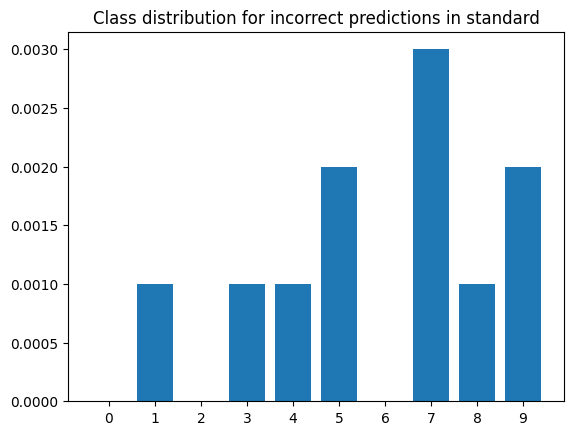

defaultdict(<class 'list'>, {0: [np.float64(0.0), np.float64(0.0034965034965034965), np.float64(0.0013175230566534915), np.float64(0.0030135610246107484), np.float64(0.006670478368591576), np.float64(0.01593625498007968), np.float64(0.038473189942441685), np.float64(0.07845622119815668), np.float64(0.12095585599222441), np.float64(0.0987183119718662)], 1: [np.float64(0.2545454545454545), np.float64(0.2517482517482518), np.float64(0.2437417654808959), np.float64(0.23204419889502761), np.float64(0.23346674290070515), np.float64(0.22535313292285403), np.float64(0.21563713475255433), np.float64(0.18888772517804775), np.float64(0.15605755212275238), np.float64(0.11236853947565793)], 2: [np.float64(0.16363636363636364), np.float64(0.14335664335664336), np.float64(0.13306982872200263), np.float64(0.10999497739829231), np.float64(0.08366685725176291), np.float64(0.06780152118797537), np.float64(0.058026493349122854), np.float64(0.05511101801424382), np.float64(0.08880585718724357), np.float64(

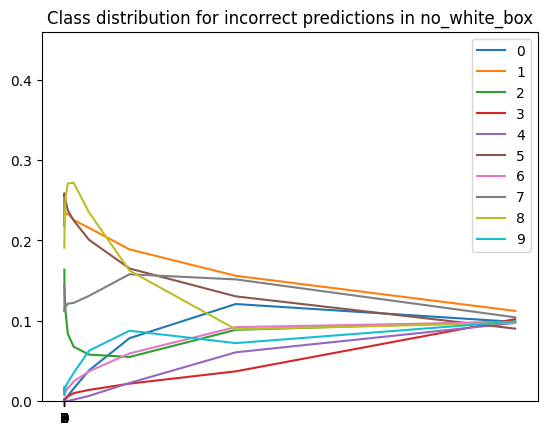

1735357095.0961316
1735357250.183092


: 

: 

In [23]:
for analysis_name, analysis in analysis_dict.items():
    dataset = analysis["dataset"]
    predictions = analysis["predictions"]
    influence_scores = analysis["influence_scores"]

    targets = dataset.targets.numpy(force=True)
    data = dataset.data.numpy(force=True)

    zero_one_loss = predictions == targets
    print(f"Accuracy on {analysis_name}: {zero_one_loss.mean()}")

    correct_idxs = np.where(zero_one_loss)
    incorrect_idxs = np.where(~zero_one_loss)

    incorrect_classes = np.bincount(predictions[incorrect_idxs]) / len(predictions)
    plt.bar(
        list(range(10)),
        incorrect_classes,
    )
    plt.xticks(list(range(10)),[str(x) for x in range(len(incorrect_classes))])
    plt.title(f"Class distribution for incorrect predictions in {analysis_name}")
    plt.show()

    # plot_most_influencial_images(
    #     image_idxs=torch.arange(1),
    #     influence_scores=influence_scores,
    #     train_dataset=train_dataset.data,
    #     test_dataset=data,
    #     predictions=predictions,
    #     targets=targets,
    #     top_k=5,
    #     title=f"Most influencial images for incorrect classes in {analysis_name}",
    # )

    plot_influence_rank_by_class(
        influence_scores=influence_scores,
        train_targets=train_dataset.targets.numpy(force=True),
        base=10,
        image_idxs=incorrect_idxs[:100] # First 100 otherwise this calculatoin can be very slow.
    )